
<h1 align="center"> Project Statistics </h1>


# Data Preprocessing

We firstly import the necessary libraries.

In [21]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.stats import kruskal
import pingouin as pg
from statsmodels.stats.anova import AnovaRM
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols

Create the folders in which the results will be stored.

In [22]:
# Create directories to store the results
if not os.path.exists('general'):
    os.makedirs('general')

if not os.path.exists('by_participants'):
    os.makedirs('by_participants')

if not os.path.exists('by_country'):
    os.makedirs('by_country')

if not os.path.exists('by_affiliation'):
    os.makedirs('by_affiliation')

if not os.path.exists('by_affiliation_country'):
    os.makedirs('by_affiliation_country')

if not os.path.exists('plots'):
    os.makedirs('plots')

Filter extracted columns

In [23]:
from pathlib import Path

filtered_path = "filtered_pullreq.csv"

if not Path(filtered_path).exists():
    # Source Dataset
    file_path = 'new_pullreq.csv'

    columns_to_extract = ['ownername', 'reponame', 'lifetime_minutes', 'mergetime_minutes', 'num_commits', 'num_commit_comments', 
                          'num_issue_comments', 'num_comments', 'num_participants', 'team_size', 'requester_succ_rate', 
                          'first_response_time', 'core_member', 'contrib_country', 'contrib_affiliation', 'inte_country', 'inte_affiliation', 
                          'same_country', 'same_affiliation', 'contrib_rate_author']
    
    # Extract the specified columns into a file
    df = pd.read_csv(file_path)
    selected_columns = df[columns_to_extract]    
    selected_columns.to_csv(filtered_path, index=False)

Load the data and display the first few rows.

In [24]:
columns_to_extract = ['ownername', 'reponame', 'lifetime_minutes', 'mergetime_minutes', 'num_commits', 'num_commit_comments', 
                      'num_issue_comments', 'num_comments', 'num_participants', 'team_size', 'requester_succ_rate', 
                      'first_response_time', 'core_member', 'contrib_country', 'contrib_affiliation', 'inte_country', 'inte_affiliation', 
                      'same_country', 'same_affiliation', 'contrib_rate_author']

# Read the CSV file into a DataFrame
df = pd.read_csv(filtered_path)

# Extract the specified columns
selected_columns = df[columns_to_extract]
print("Total number of projects: ", selected_columns.shape[0])

Total number of projects:  3347937


In order to compute the statistics, the data is firstly cleaned, therefore ensuring no unpredicatble behaviour.

In [25]:

# Modify the data in order to be able to compute statistics
selected_columns['mergetime_minutes'] = pd.to_numeric(selected_columns['mergetime_minutes'], errors='coerce')
selected_columns['num_participants'] = pd.to_numeric(selected_columns['num_participants'], errors='coerce')
selected_columns['requester_succ_rate'] = pd.to_numeric(selected_columns['requester_succ_rate'], errors='coerce')
selected_columns['first_response_time'] = pd.to_numeric(selected_columns['first_response_time'], errors='coerce')

# Remove negative values present in the column
selected_columns["first_response_time"] = selected_columns["first_response_time"][selected_columns["first_response_time"] >= 0]

selected_columns.dropna(subset=['mergetime_minutes'], inplace=True)
selected_columns.dropna(subset=['requester_succ_rate'], inplace=True)
selected_columns.dropna(subset=['first_response_time'], inplace=True)

# Statistics Computation

### General statistics about the dataset

In [26]:
# compute statistics
stats = selected_columns.describe()
stats.to_csv('general/stats_general.csv')

## Research Question 1

### General statistics

Separate the dataset into two groups, first by country and then by affiliation.

In [27]:
# Statistics for projects where the contributor and integrator come from the same country
same_country = selected_columns[selected_columns['same_country'] == int(True)]
print("Number of projects where contributor and integrator come from the same country: ", same_country.shape[0], ", percentage: ", same_country.shape[0]/selected_columns.shape[0] * 100, "%")
# print(same_country.describe())

# Statistics for projects where the contributor and integrator come from different countries
not_same_country = selected_columns[selected_columns['same_country'] != int(True)]
print("Number of projects where contributor and integrator come from different countries: ", not_same_country.shape[0], ", percentage: ", not_same_country.shape[0]/selected_columns.shape[0] * 100, "%")
# print(not_same_country.describe())

# Statistics for projects where the contributor and integrator come from the same affiliation
same_affiliation = selected_columns[selected_columns['same_affiliation'] == int(True)]
print("Number of projects where contributor and integrator come from the same affiliation: ", same_affiliation.shape[0], ", percentage: ", same_affiliation.shape[0]/selected_columns.shape[0] * 100, "%")
# print(same_country.describe())

# Statistics for projects where the contributor and integrator come from different affiliations
not_same_affiliation = selected_columns[selected_columns['same_affiliation'] != int(True)]
print("Number of projects where contributor and integrator come from different affiliations: ", not_same_affiliation.shape[0], ", percentage: ", not_same_affiliation.shape[0]/selected_columns.shape[0] * 100, "%")
# print(not_same_affiliation.describe())

# Statistics for projects where the contributor and integrator come from the same affiliation and country
same_affiliation_country = selected_columns[(selected_columns['same_affiliation'] == int(True)) & (selected_columns['same_country'] == int(True))]
print("Number of projects where contributor and integrator come from the same affiliation and country: ", same_affiliation_country.shape[0], ", percentage: ", same_affiliation_country.shape[0]/selected_columns.shape[0] * 100, "%")
# print(same_affiliation_country.describe())

Number of projects where contributor and integrator come from the same country:  318202 , percentage:  25.034301970632477 %
Number of projects where contributor and integrator come from different countries:  952862 , percentage:  74.96569802936752 %
Number of projects where contributor and integrator come from the same affiliation:  238735 , percentage:  18.782295777395948 %
Number of projects where contributor and integrator come from different affiliations:  1032329 , percentage:  81.21770422260406 %
Number of projects where contributor and integrator come from the same affiliation and country:  104333 , percentage:  8.208319958711757 %


Save the general statistics of each group.

In [28]:
same_country.describe().to_csv('by_country/same_country.csv')
not_same_country.describe().to_csv('by_country/not_same_country.csv')
same_affiliation.describe().to_csv('by_affiliation/same_affiliation.csv')
not_same_affiliation.describe().to_csv('by_affiliation/not_same_affiliation.csv')
same_affiliation_country.describe().to_csv('by_affiliation_country/same_affiliation_country.csv')

### Significance testing

#### 1. Kruskal-Wallis H test

Perform a Kruskal-Wallis H test to determine if the mean of the two groups is significantly different.

In [29]:
# Compute the Kruskal-Wallis H-test for mergetime
country_mergetime_kruskal = kruskal(same_country['mergetime_minutes'], not_same_country['mergetime_minutes'])
affiliation_mergetime_kruskal = kruskal(same_affiliation['mergetime_minutes'], not_same_affiliation['mergetime_minutes'])

# Compute the Kruskal-Wallis H-test for requester_succ_rate
country_success_rate_kruskal = kruskal(same_country['requester_succ_rate'], not_same_country['requester_succ_rate'])
affiliation_success_rate_kruskal = kruskal(same_affiliation['requester_succ_rate'], not_same_affiliation['requester_succ_rate'])

# Compute the Kruskal-Wallis H-test for first_response_time
country_first_response_time_kruskal = kruskal(same_country['first_response_time'], not_same_country['first_response_time'])
affiliation_first_response_time_kruskal = kruskal(same_affiliation['first_response_time'], not_same_affiliation['first_response_time'])

# Print the results
print("Kruskal-Wallis H-test for mergetime by country: ", country_mergetime_kruskal)
print("Kruskal-Wallis H-test for mergetime by affiliation: ", affiliation_mergetime_kruskal)

print("Kruskal-Wallis H-test for requester_succ_rate by country: ", country_success_rate_kruskal)
print("Kruskal-Wallis H-test for requester_succ_rate by affiliation: ", affiliation_success_rate_kruskal)

print("Kruskal-Wallis H-test for first_response_time by country: ", country_first_response_time_kruskal)
print("Kruskal-Wallis H-test for first_response_time by affiliation: ", affiliation_first_response_time_kruskal)


Kruskal-Wallis H-test for mergetime by country:  KruskalResult(statistic=13329.838818668743, pvalue=0.0)
Kruskal-Wallis H-test for mergetime by affiliation:  KruskalResult(statistic=6151.197003429902, pvalue=0.0)
Kruskal-Wallis H-test for requester_succ_rate by country:  KruskalResult(statistic=2378.7025800336733, pvalue=0.0)
Kruskal-Wallis H-test for requester_succ_rate by affiliation:  KruskalResult(statistic=3184.347597612321, pvalue=0.0)
Kruskal-Wallis H-test for first_response_time by country:  KruskalResult(statistic=2144.959027370105, pvalue=0.0)
Kruskal-Wallis H-test for first_response_time by affiliation:  KruskalResult(statistic=4585.071549168574, pvalue=0.0)


#### 2. Eta-squared (η²) test

Perform an Eta-squared test to determine the effect size of the difference between the two groups.

In order to do so, we first define the function that computes the Eta-squared test.

In [30]:
def compute_eta_squared(groups, labels):
    # Convert each group into a numpy array
    groups = [np.array(group) for group in groups]
    
    # Combine the data and create a corresponding group label
    data = np.concatenate(groups)
    ll = []
    for i, group in enumerate(labels):
        ll += [labels[i]] * len(groups[i])

    # Create a DataFrame for the data
    df = pd.DataFrame({'data': data, 'group': ll})
    
    # Perform one-way ANOVA
    model = ols('data ~ C(group)', data=df).fit()
    anova_table = sm.stats.anova_lm(model)

    # Calculate eta-squared
    ss_between = anova_table['sum_sq'].iloc[0]
    ss_total = ss_between + anova_table['sum_sq'].iloc[1]
    eta_squared = ss_between / ss_total

    return eta_squared

Then, we perform the test.

In [31]:
# Compute the Eta-squared for mergetime
country_mergetime_eta = compute_eta_squared([same_country['mergetime_minutes'], not_same_country['mergetime_minutes']], ['Same country', 'Not same country'])
affiliation_mergetime_eta = compute_eta_squared([same_affiliation['mergetime_minutes'], not_same_affiliation['mergetime_minutes']], ['Same affiliation', 'Not same affiliation'])

# Compute the Eta-squared for requester_succ_rate
country_success_rate_eta = compute_eta_squared([same_country['requester_succ_rate'], not_same_country['requester_succ_rate']], ['Same country', 'Not same country'])
affiliation_success_rate_eta = compute_eta_squared([same_affiliation['requester_succ_rate'], not_same_affiliation['requester_succ_rate']], ['Same affiliation', 'Not same affiliation'])

# Compute the Eta-squared for first_response_time
country_first_response_time_eta = compute_eta_squared([same_country['first_response_time'], not_same_country['first_response_time']], ['Same country', 'Not same country'])
affiliation_first_response_time_eta = compute_eta_squared([same_affiliation['first_response_time'], not_same_affiliation['first_response_time']], ['Same affiliation', 'Not same affiliation'])

# Print the results
print("Eta-squared for mergetime by country: ", country_mergetime_eta)
print("Eta-squared for mergetime by affiliation: ", affiliation_mergetime_eta)

print("Eta-squared for requester_succ_rate by country: ", country_success_rate_eta)
print("Eta-squared for requester_succ_rate by affiliation: ", affiliation_success_rate_eta)

print("Eta-squared for first_response_time by country: ", country_first_response_time_eta)
print("Eta-squared for first_response_time by affiliation: ", affiliation_first_response_time_eta)

Eta-squared for mergetime by country:  0.0017749227726841018
Eta-squared for mergetime by affiliation:  0.0026216083843160517
Eta-squared for requester_succ_rate by country:  0.01494628772035413
Eta-squared for requester_succ_rate by affiliation:  0.020459671665929307
Eta-squared for first_response_time by country:  0.0006311292042095129
Eta-squared for first_response_time by affiliation:  0.0009669331046255358


## Research Question 2

### General statistics

Separate the dataset into 3 groups by the number of participants.

In [32]:
# Number of participants delimitations
low_limit = 10
medium_limit = 20

# Split the projects into three categories based on the number of participants
low_participants = selected_columns[selected_columns['num_participants'] < low_limit]
print("Number of projects with low number of participants: ", low_participants.shape[0], ", percentage: ", low_participants.shape[0]/selected_columns.shape[0] * 100, "%")

medium_participants = selected_columns[(selected_columns['num_participants'] >= low_limit) & (selected_columns['num_participants'] < medium_limit)]
print("Number of projects with medium number of participants: ", medium_participants.shape[0], ", percentage: ", medium_participants.shape[0]/selected_columns.shape[0] * 100, "%")

high_participants = selected_columns[(selected_columns['num_participants'] >= medium_limit)]
print("Number of projects with high number of participants: ", high_participants.shape[0], ", percentage: ", high_participants.shape[0]/selected_columns.shape[0] * 100, "%")

Number of projects with low number of participants:  1268867 , percentage:  99.82715268467992 %
Number of projects with medium number of participants:  2115 , percentage:  0.1663960272653462 %
Number of projects with high number of participants:  82 , percentage:  0.006451288054732098 %


Save the general statistics of each group.

In [33]:
low_participants.describe().to_csv('by_participants/low_participants.csv')
medium_participants.describe().to_csv('by_participants/medium_participants.csv')
high_participants.describe().to_csv('by_participants/high_participants.csv')

### Significance testing

#### 1. Kruskal-Wallis H test

Perform a Kruskal-Wallis H test to determine if the mean of the three groups is significantly different.

In [34]:
# Kruskal-Wallis H-test for mergetime, requester success rate and first response time by number of participants
participants_mergetime_kruskal = kruskal(low_participants['mergetime_minutes'], medium_participants['mergetime_minutes'], high_participants['mergetime_minutes'])
participants_requester_succ_rate_kruskal = kruskal(low_participants['requester_succ_rate'], medium_participants['requester_succ_rate'], high_participants['requester_succ_rate'])
participants_first_response_time_kruskal = kruskal(low_participants['first_response_time'], medium_participants['first_response_time'], high_participants['first_response_time'])

# Print the results
print("Kruskal-Wallis H-test for mergetime by number of participants: ", participants_mergetime_kruskal)
print("Kruskal-Wallis H-test for requester success rate by number of participants: ", participants_requester_succ_rate_kruskal)
print("Kruskal-Wallis H-test for first response time by number of participants: ", participants_first_response_time_kruskal)

Kruskal-Wallis H-test for mergetime by number of participants:  KruskalResult(statistic=4465.993362195328, pvalue=0.0)
Kruskal-Wallis H-test for requester success rate by number of participants:  KruskalResult(statistic=48.8188239349107, pvalue=2.5068426563494003e-11)
Kruskal-Wallis H-test for first response time by number of participants:  KruskalResult(statistic=385.19997059947315, pvalue=2.2640664525953957e-84)


#### 2. Eta-squared (η²) test

Perform an Eta-squared test to determine the effect size of the difference between the three groups.

In [35]:
# Compute the Eta-squared for mergetime by number of participants
participants_mergetime_eta = compute_eta_squared([low_participants['mergetime_minutes'], medium_participants['mergetime_minutes'], high_participants['mergetime_minutes']], ['Low participants', 'Medium participants', 'High participants'])

# Compute the Eta-squared for requester_succ_rate by number of participants
participants_requester_succ_rate_eta = compute_eta_squared([low_participants['requester_succ_rate'], medium_participants['requester_succ_rate'], high_participants['requester_succ_rate']], ['Low participants', 'Medium participants', 'High participants'])

# Compute the Eta-squared for first_response_time by number of participants
participants_first_response_time_eta = compute_eta_squared([low_participants['first_response_time'], medium_participants['first_response_time'], high_participants['first_response_time']], ['Low participants', 'Medium participants', 'High participants'])

# Print the results
print("Eta-squared for mergetime by number of participants: ", participants_mergetime_eta)
print("Eta-squared for requester success rate by number of participants: ", participants_requester_succ_rate_eta)
print("Eta-squared for first response time by number of participants: ", participants_first_response_time_eta)

Eta-squared for mergetime by number of participants:  0.01053800523602216
Eta-squared for requester success rate by number of participants:  0.000160193358278346
Eta-squared for first response time by number of participants:  1.1642797085163482e-06


# Results Visualization

## Research Question 1

Firstly, we plot the signiidicant results by the `same_country`.

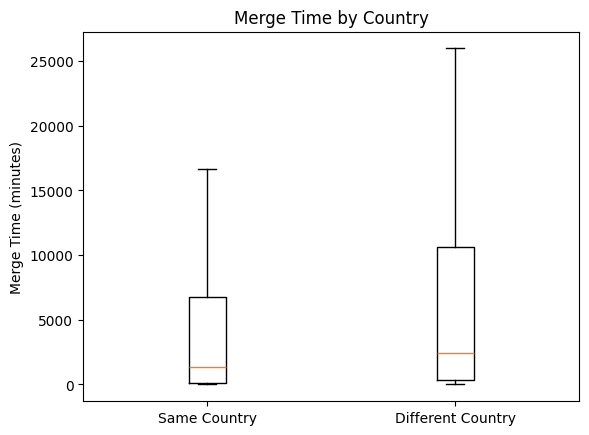

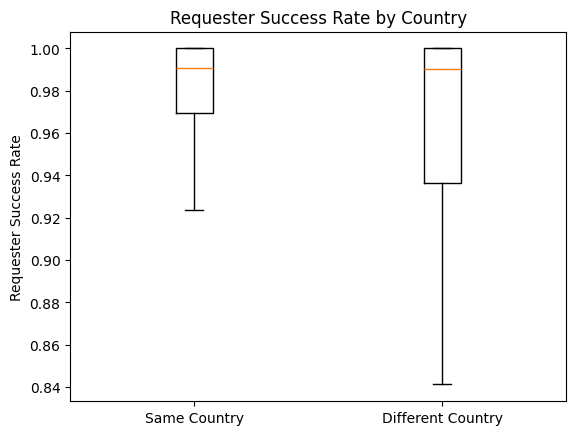

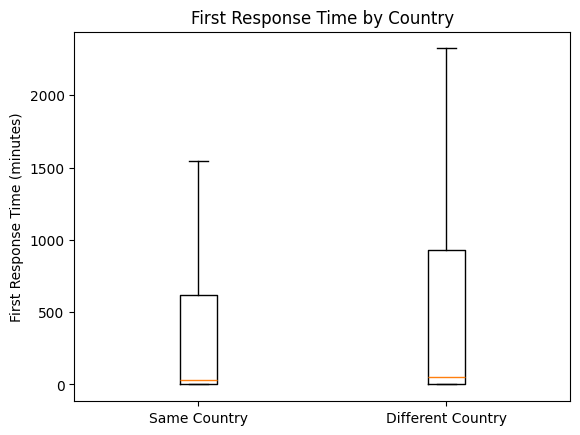

In [36]:
# Plot the distribution of the merge time  by the country of the contributor/integrator
plt.figure()
plt.boxplot([same_country['mergetime_minutes'], not_same_country['mergetime_minutes']], showfliers=False)
plt.xticks([1, 2], ['Same Country', 'Different Country'])
plt.ylabel('Merge Time (minutes)')
plt.title('Merge Time by Country')
plt.savefig('plots/merge_time_by_country.png')

# Plot the distribution of the requester success rate by the country of the contributor/integrator
plt.figure()
plt.boxplot([same_country['requester_succ_rate'], not_same_country['requester_succ_rate']], showfliers=False)
plt.xticks([1, 2], ['Same Country', 'Different Country'])
plt.ylabel('Requester Success Rate')
plt.title('Requester Success Rate by Country')
plt.savefig('plots/requester_success_rate_by_country.png')

# Plot the distribution of the first response time by the country of the contributor/integrator
plt.figure()
plt.boxplot([same_country['first_response_time'], not_same_country['first_response_time']], showfliers=False)
plt.xticks([1, 2], ['Same Country', 'Different Country'])
plt.ylabel('First Response Time (minutes)')
plt.title('First Response Time by Country')
plt.savefig('plots/first_response_time_by_country.png')

Then, we plot the significant results by the `same_affiliation`.

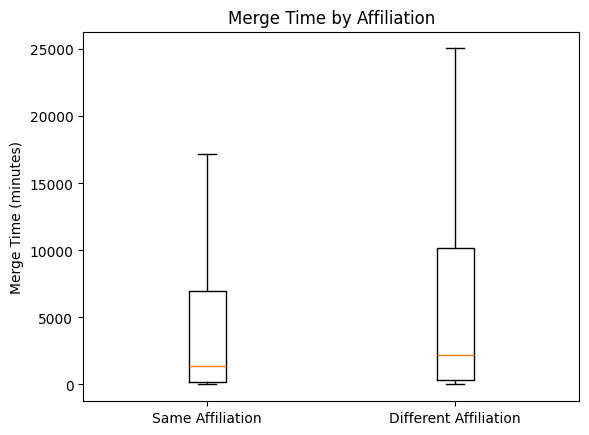

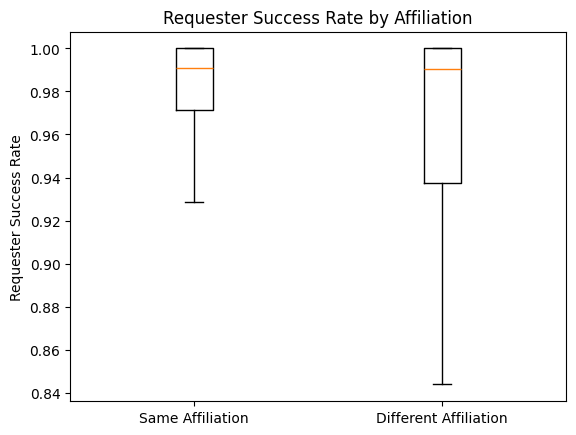

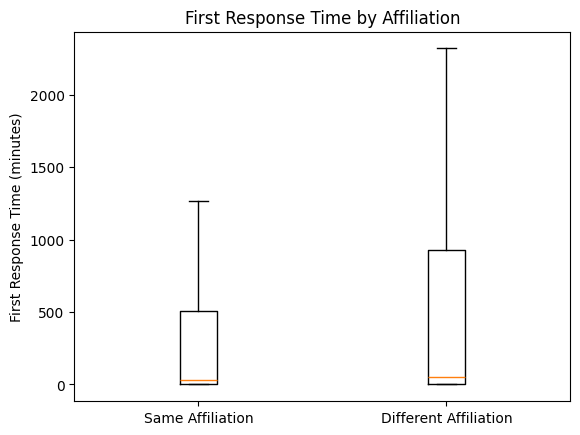

In [37]:
# Plot the distribution of the merge time by the affiliation of the contributor/integrator
plt.figure()
plt.boxplot([same_affiliation['mergetime_minutes'], not_same_affiliation['mergetime_minutes']], showfliers=False)
plt.xticks([1, 2], ['Same Affiliation', 'Different Affiliation'])
plt.ylabel('Merge Time (minutes)')
plt.title('Merge Time by Affiliation')
plt.savefig('plots/merge_time_by_affiliation.png')

# Plot the distribution of the requester success rate by the affiliation of the contributor/integrator
plt.figure()
plt.boxplot([same_affiliation['requester_succ_rate'], not_same_affiliation['requester_succ_rate']], showfliers=False)
plt.xticks([1, 2], ['Same Affiliation', 'Different Affiliation'])
plt.ylabel('Requester Success Rate')
plt.title('Requester Success Rate by Affiliation')
plt.savefig('plots/requester_success_rate_by_affiliation.png')

# Plot the distribution of the first response time by the affiliation of the contributor/integrator
plt.figure()
plt.boxplot([same_affiliation['first_response_time'], not_same_affiliation['first_response_time']], showfliers=False)
plt.xticks([1, 2], ['Same Affiliation', 'Different Affiliation'])
plt.ylabel('First Response Time (minutes)')
plt.title('First Response Time by Affiliation')
plt.savefig('plots/first_response_time_by_affiliation.png')

## Research Question 2

Plot the significant results of the statistical tests.

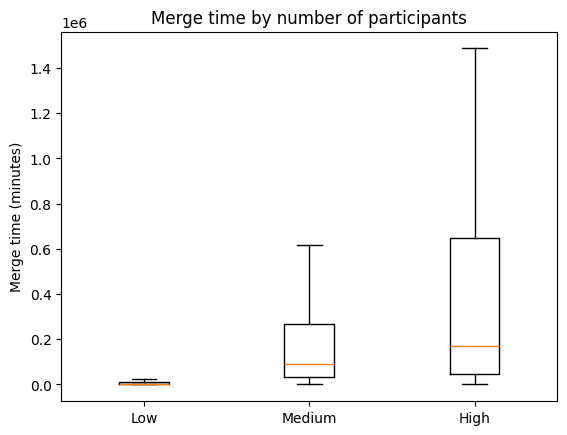

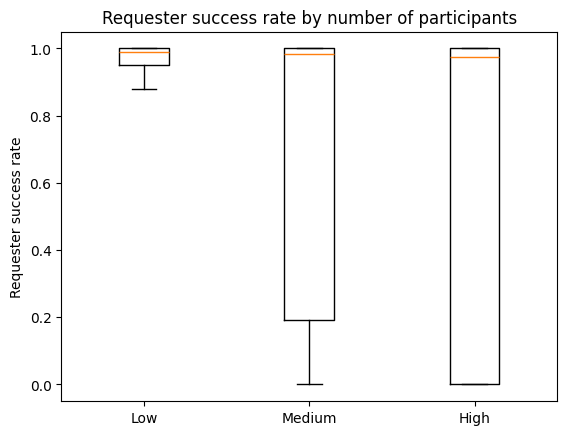

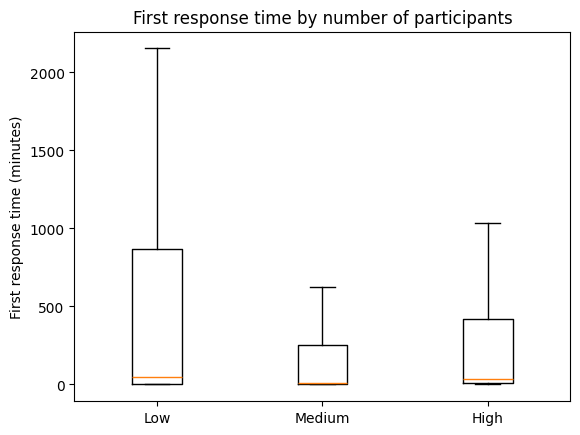

In [38]:
# Plot the distribution of merge time by number of participants
plt.figure()
plt.boxplot([low_participants['mergetime_minutes'], medium_participants['mergetime_minutes'], high_participants['mergetime_minutes']], showfliers=False)
plt.xticks([1, 2, 3], ['Low', 'Medium', 'High'])
plt.ylabel('Merge time (minutes)')
plt.title('Merge time by number of participants')
plt.savefig('plots/merge_time_by_participants.png')
plt.show()

# Plot the distribution of requester success rate by number of participants
plt.figure()
plt.boxplot([low_participants['requester_succ_rate'], medium_participants['requester_succ_rate'], high_participants['requester_succ_rate']], showfliers=False)
plt.xticks([1, 2, 3], ['Low', 'Medium', 'High'])
plt.ylabel('Requester success rate')
plt.title('Requester success rate by number of participants')
plt.savefig('plots/requester_success_rate_by_participants.png')
plt.show()

# Plot the distribution of first response time by number of participants
plt.figure()
plt.boxplot([low_participants['first_response_time'], medium_participants['first_response_time'], high_participants['first_response_time']], showfliers=False)
plt.xticks([1, 2, 3], ['Low', 'Medium', 'High'])
plt.ylabel('First response time (minutes)')
plt.title('First response time by number of participants')
plt.savefig('plots/first_response_time_by_participants.png')
plt.show()